<a href="https://colab.research.google.com/github/ale-chen/ML-Projects/blob/main/Support%20Vector%20Machines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

dfUnclean = pd.read_csv("drive/MyDrive/epi_r.csv")

In [ ]:
#PREPROCESSING

#Deal with rows with missing values;
df = dfUnclean.dropna()
df = dfUnclean.dropna(axis = 0)
df.dropna(axis = 0, inplace = True)
df.drop_duplicates(inplace = True)

#Deal with columns with zero variance; 
df = df.loc[:, (df != df.iloc[0]).any()]

X = df.drop(['cake','title'], axis = 1)
y = df['cake'].tolist()

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size = 0.25, random_state = 7)

#Scale Train Data
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
scale.fit(X_tr)
X_tr_scaled = scale.transform(X_tr, copy = True)
X_te_scaled = scale.transform(X_te, copy = True)

# **Support Vector Machines**
1. Using the Epicurious dataset, use support vector machines to predict whether or not a recipe is tagged
as cake. You may experiment with the features (i.e., use different combinations, use the principal
components from last homework, etc.). Report your accuracy, sensitivity, specificity, etc.
2. Plot the ROC curve for your support vector machine model. Add the ROC curve from your best model
from Homework 5A to same plot. Find the areas under the curve for both models. Which one performs
better?

In [ ]:
from sklearn.svm import SVC
import warnings
warnings.filterwarnings("ignore")

clfLinear = SVC(C=1, probability=True, kernel = 'linear', max_iter = 500)
clfRBF = SVC(C=1, probability=True, kernel = 'rbf', max_iter = 500)

clfLinear.fit(X_tr_scaled,y_tr)
clfRBF.fit(X_tr_scaled,y_tr)

*Using scaled data, between two different kerneling techniques.*

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = clfLinear.predict(X_te_scaled)

cmL = confusion_matrix(y_te, y_pred)

tp, fp, fn, tn = cmL[0,0], cmL[1,0], cmL[0,1], cmL[1,1]

print("Accuracy (Linear SVM): " + str((tp + tn) /(tn + fp + fn + tp)))
print("Sensitivity (Linear SVM): " + str(tp / (tp+fn)))
print("Specificity (Linear SVM): " + str(tn / (tn+fp)))

y_pred = clfRBF.predict(X_te_scaled)

cmR = confusion_matrix(y_te, y_pred)

tp, fp, fn, tn = cmR[0,0], cmR[1,0], cmR[0,1], cmR[1,1]
print("Accuracy (RBF SVM): " + str((tp + tn) /(tn + fp + fn + tp)))
print("Sensitivity (RBF SVM): " + str(tp / (tp+fn)))
print("Specificity (RBF SVM): " + str(tn / (tn+fp)))

Accuracy (Linear SVM): 0.8064784053156147
Sensitivity (Linear SVM): 0.8178664353859497
Specificity (Linear SVM): 0.5490196078431373
Accuracy (RBF SVM): 0.9631782945736435
Sensitivity (RBF SVM): 0.9985544955189362
Specificity (RBF SVM): 0.16339869281045752


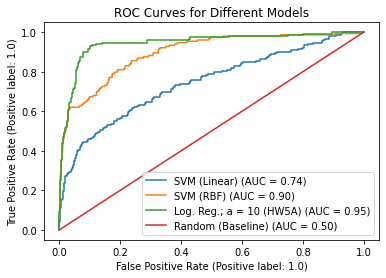

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_tr, y_tr)

clf_5A = LogisticRegression(solver = "liblinear", penalty = 'l1', C = .1, max_iter = 100).fit(X_tr_scaled, y_tr) #clf from HW 5A

ROCLinear = RocCurveDisplay.from_estimator(clfLinear, X_te_scaled, y_te, name = 'SVM (Linear)')

ROCRBF = RocCurveDisplay.from_estimator(clfRBF, X_te_scaled, y_te, name = 'SVM (RBF)', ax = ROCLinear.ax_)

ROC5A = RocCurveDisplay.from_estimator(clf_5A, X_te_scaled, y_te, name = 'Log. Reg.; a = 10 (HW5A)', ax = ROCLinear.ax_)

ROCDumb = RocCurveDisplay.from_estimator(dummy, X_te_scaled, y_te, name = 'Random (Baseline)', ax = ROCLinear.ax_)

plt.title("ROC Curves for Different Models")

plt.show()

Clearly, the Logistic Regression performs better than the other classifiers. However, keep in mind that I had to limit the number of iterations for the svm models due to runtimes being incredibly long. The SVM performance would likely be much better than the logistic regression if given enough iterations.

# ***k*-Means Clustering**
1. Apply k-means clustering for a range of k to all of the Epicurious features. Most of the features are categorical and should already be coded as indicator variables (0’s and 1’s), but there are a few numeric variables corresponding to the nutrition facts for each recipe. Make a plot of the Akaike Information Criterion (AIC) and Bayesian Information Criterion (BIC) for the residual within cluster variance as a function of k and choose the best k.
2. Using the k that you found in the previous step, produce a visualization that explains how some of the clusters differ using the following steps:
> * So that you can visualize the clusters in two dimensions at a time, perform Principal Component Analysis (a.k.a., singular value decomposition). This should be very similar to your analysis from Homework 5A, Part 2.
> * Create scatter plots of the first two principal components, PC1 and PC2. Label the axes with the fraction of the variance explained by PC1 and PC2.
> * Color each point according to the cluster labels.
> * Repeat the previous two steps for the following pairs of components: PC3 and PC4, PC5 and PC6, PC7 and PC8, and PC9 and PC10. You should not have to re-perform PCA on the features.
3. Try to come up with a "name" or description for at least a few of the clusters–are they easily interpretable?

In [ ]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

def getBIC_AIC(k, X):
    gmm = GaussianMixture(n_components=k, init_params='kmeans')
    gmm.fit(X)
    return gmm.bic(X), gmm.aic(X)

def getKM(k, X):
    km = KMeans(n_clusters=k, random_state=37)
    km.fit(X)
    return km

def get_score(k, X, y):
    km = getKM(k, X)
    y_pred = km.predict(X)
    bic, aic = getBIC_AIC(k, X)
    return k, bic, aic, km

In [ ]:
scores = [get_score(k, X_tr_scaled, y_tr) for k in range(2, 11)]

df = pd.DataFrame([scores[i][0:3] for i in range(len(scores))], columns=['k', 'BIC', 'AIC'])

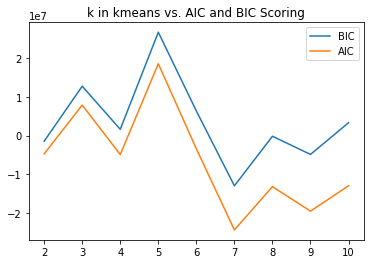

In [ ]:
plt.plot(df['k'],df['BIC'], label = "BIC")
plt.plot(df['k'],df['AIC'], label = "AIC")
plt.title("k in kmeans vs. AIC and BIC Scoring")
plt.legend()
plt.show()

k with lowest (best) score is k = 7.

# **Perform PCA**

In [ ]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_tr_scaled)

PCA()

In [ ]:
pcaResult = pca.fit_transform(X_tr_scaled)
pcaResult = pcaResult[:,0:10]
print(pcaResult)
pcs = pd.DataFrame(data = pcaResult, columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6','PC7', 'PC8', 'PC9', 'PC10'])

[[-5.31846036 -2.45909366  4.94806771 ... -0.18398046 -4.150977
   2.23674354]
 [-1.16475754  2.22067231 -2.06339297 ...  1.4501306   0.55271429
  -1.47579047]
 [ 3.03996158 -3.42112886 -0.9984524  ... -1.41185185  0.207663
  -0.55776195]
 ...
 [ 1.58236031  0.48020635 -2.50744065 ... -2.25391383  1.06958413
  -0.22040721]
 [-2.51784286  2.44329541  0.30691668 ...  0.06991199 -0.33035913
  -1.00576501]
 [-2.39924065 -1.29210625  0.30575721 ... -1.16615323 -2.65457939
   0.30109487]]


KMeans(n_clusters=7, random_state=37)


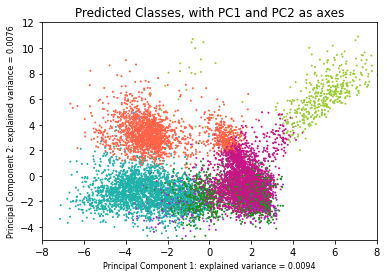

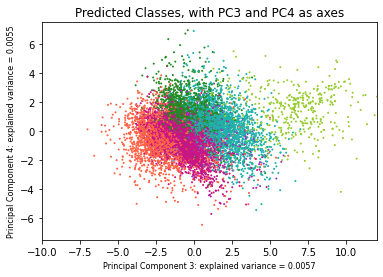

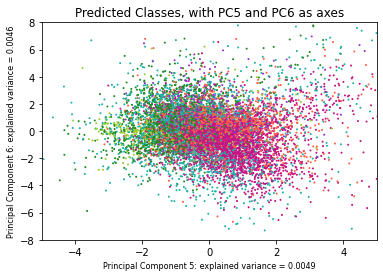

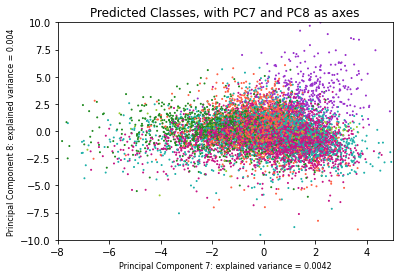

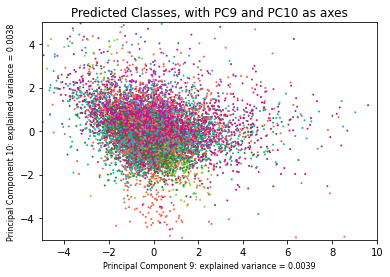

In [ ]:
scores = np.array(scores)

print(scores[5,3])
y_pred = scores[5,3].predict(X_tr_scaled)

colorIndex = {
    0: "tomato",
    1: "yellowgreen",
    2: "forestgreen",
    3: "lightseagreen",
    4: "cornflowerblue",
    5: "darkorchid",
    6: "mediumvioletred"
}

scales = [
    [[-8,8],[-5,12]],
    [[-10,12],[-7.5,7.5]],
    [[-5,5],[-8,8]],
    [[-8,5],[-10,10]],
    [[-5,10],[-5,5]]
]

c = []

for i in y_pred:
  c.append(colorIndex[i])
for i in range(5):
  plt.scatter(pcs['PC' + str(i * 2 + 1)], pcs['PC' + str(i * 2 + 2)], c = c, s = 1)
  plt.xlabel("Principal Component " + str(i * 2 + 1) +": explained variance = " + str(pca.explained_variance_ratio_[i * 2 + 1].round(4)), fontsize = 8)
  plt.ylabel("Principal Component " + str(i * 2 + 2) +": explained variance = " + str(pca.explained_variance_ratio_[i * 2 + 2].round(4)), fontsize = 8)
  plt.title("Predicted Classes, with PC" + str(i * 2 + 1) +" and PC" + str(i * 2 + 2) +" as axes")
  plt.xlim(scales[i][0][0],scales[i][0][1])
  plt.ylim(scales[i][1][0],scales[i][1][1])
  plt.show()

In [ ]:
fullcomponents = pca.components_
components0 = pca.components_[0]
components1 = pca.components_[1]

pc1Components = []
pc2Components = []

for i in range(5):
  pc1Components.append(X_tr.columns[np.where(components0 == max(components0, key = abs))[0][0]])
  components0 = np.delete(components0, np.where(components0 == max(components0, key = abs))[0][0])

  pc2Components.append(X_tr.columns[np.where(components1 == max(components1, key = abs))[0][0]])
  components1 = np.delete(components1, np.where(components1 == max(components1, key = abs))[0][0])

print("PC1 Top 5 Components: " + str(pc1Components))
print("PC2 Top 5 Components: " + str(pc2Components))

PC1 Top 5 Components: ['peanut free', 'soy', 'peru', 'kosher', 'tomatillo']
PC2 Top 5 Components: ['dessert', 'dried fruit', 'alcoholic', 'cocktail', 'cobbler/crumble']


We see two main clefts in the Principal Component 1, at x = 0, x = 4. Let us assume that the x = 0 separation is due to the "peanut free" dimension, and the x = 4 is due to the "soy" dimension.

We see two main clefts in the Principal Component 2, at y = 1, y = 5. Let us assume that the y = 1 separation is due to the "dessert" dimension, and the y = 5 is due to the "dried fruit" dimension.

Based on this we can assign several values to the following clusters:

**Orange:** (We know this to be approximately cake from 5A): some soy, some not soy, all peanut free; all dessert, most not dried fruit.

**Blue:** Peanut Free, No Soy; Not a Dessert, No Dried Fruit.

**Violet:** Has Soy, Peanut Free; Some Dessert, Some not Dessert.

**Dark Green:** Has Soy, Peanut Free; All Dessert, No Dried Fruit.

**Lime:** Dried Fruit, Dessert; Not Peanut Free, Not Soy